In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns


# Data Preprocessing

In [5]:
data = pd.read_csv('../data/data_train.csv', index_col=0)

# rename column and turn ot uint8
data.rename(columns={'Prediction': 'Rating'}, inplace=True)
data['Rating'] = data['Rating'].astype('uint8')

# get user and movie id by splitting index given in format rX_cY
data['UserId'] = data.index.str.split('_').str[0].str[1:].astype('int32')
data['MovieId'] = data.index.str.split('_').str[1].str[1:].astype('int32')

# subtract min UserId and MovieID to get indices starting at 0
data['UserId'] = data['UserId'] - data['UserId'].min()
data['MovieId'] = data['MovieId'] - data['MovieId'].min()

# reorder columns to UserId, MovieId, Rating
data = data[['UserId', 'MovieId', 'Rating']]

# split into train and val data
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

In [6]:
data['copy_index'] = data.index
data.head()


,UserId,MovieId,Rating,copy_index
Id,,,,
r44_c1,43,0,4,r44_c1
r61_c1,60,0,3,r61_c1
r67_c1,66,0,4,r67_c1
r72_c1,71,0,3,r72_c1
r86_c1,85,0,5,r86_c1


### Compute the data characteristics on the training set

In [7]:
movie_sparsity = (10000 - data['MovieId'].value_counts())/10000
average_per_movie = data.groupby(by="MovieId")['Rating'].mean()
movie_std = data.groupby(by="MovieId")['Rating'].std()
movie_data_analysis = pd.DataFrame({'movie_sparsity':movie_sparsity, 'movie_grading_avg':average_per_movie,'movie_grading_std':movie_std})
movie_data_analysis.head()

,movie_sparsity,movie_grading_avg,movie_grading_std
MovieId,,,
0,0.9660,3.379412,1.061607
1,0.9469,3.500942,1.030433
2,0.9208,3.483586,1.073639
3,0.6836,3.936473,1.180813
4,0.8757,3.559131,1.036532


In [8]:
user_sparsity = (10000 - data['UserId'].value_counts())/10000
average_per_user = data.groupby(by="UserId")['Rating'].mean()
user_std = data.groupby(by="UserId")['Rating'].std()
user_data_analysis = pd.DataFrame({'user_sparsity':user_sparsity, 'user_grading_avg':average_per_user,'user_grading_std':user_std})
user_data_analysis.head()

,user_sparsity,user_grading_avg,user_grading_std
UserId,,,
0,0.9977,4.043478,1.065076
1,0.9851,3.771812,1.180476
2,0.9914,3.523256,1.185468
3,0.9980,3.800000,1.239694
4,0.9866,3.985075,1.054778


### Create the data_analysis matrix containing the different data characteristics of interest 

In [9]:
temp = pd.merge(data, movie_data_analysis,left_on='MovieId',right_on='MovieId', how='inner')
data_analysis = pd.merge(temp, user_data_analysis,left_on='UserId', right_on='UserId', how='inner')
data_analysis.set_index(('copy_index'), drop=True, append=False, inplace=True, verify_integrity=False)
data_analysis

,UserId,MovieId,Rating,movie_sparsity,movie_grading_avg,movie_grading_std,user_sparsity,user_grading_avg,user_grading_std
copy_index,,,,,,,,,
r44_c1,43,0,4,0.9660,3.379412,1.061607,0.9746,3.893701,1.074553
r44_c2,43,1,4,0.9469,3.500942,1.030433,0.9746,3.893701,1.074553
r44_c4,43,3,5,0.6836,3.936473,1.180813,0.9746,3.893701,1.074553
r44_c5,43,4,5,0.8757,3.559131,1.036532,0.9746,3.893701,1.074553
r44_c7,43,6,2,0.8876,3.446619,1.110060,0.9746,3.893701,1.074553
...,...,...,...,...,...,...,...,...,...
r2440_c773,2439,772,2,0.8046,3.565507,1.098832,0.9979,3.380952,1.160870
r2440_c843,2439,842,4,0.9116,3.624434,1.267823,0.9979,3.380952,1.160870
r2440_c938,2439,937,1,0.9763,3.780591,0.926518,0.9979,3.380952,1.160870


### load predictions on the validation set for the 5 different trained models

In [126]:
## In order to obtain the desired plots we need to load predictions on the validation set for the 5 different trained models

prediction_ncf_df = pd.read_csv('../data/predictions_ncf_val.csv', index_col=0)
prediction_bfm_ppf_temp = pd.read_csv('../data/predictions_bfm_ppf_val.csv', index_col=0)
prediction_bfm = pd.read_csv('../data/predictions_bfm_val.csv', index_col=0)
prediction_mlp_df = pd.read_csv('../data/predictions_mlp_val.csv', index_col=0)
prediction_knn_df = pd.read_csv('../data/predictions_knn_val.csv', index_col=0)
std_bfm_val = pd.read_csv('../data/std_bfm_val.csv', index_col=0)
std_bfm_val.head()

,std
Id,
r5062_c706,0.254181
r9044_c148,0.176798
r1736_c169,0.208818
r5270_c877,0.280618
r6100_c691,0.271408


In [43]:
data_analysis = pd.merge(data_analysis, prediction_bfm, left_index=True, right_index=True)
data_analysis = pd.merge(data_analysis, std_bfm_val, left_index=True, right_index=True)

In [46]:
data_analysis

,UserId,MovieId,Rating,movie_sparsity,movie_grading_avg,movie_grading_std,user_sparsity,user_grading_avg,user_grading_std,Prediction,std,mse
r44_c5,43,4,5,0.8757,3.559131,1.036532,0.9746,3.893701,1.074553,3.805640,0.178439,1.426495
r44_c7,43,6,2,0.8876,3.446619,1.110060,0.9746,3.893701,1.074553,3.689134,0.202140,2.853174
r44_c8,43,7,5,0.6596,3.877497,1.291706,0.9746,3.893701,1.074553,3.725954,0.416098,1.623194
r44_c13,43,12,4,0.9560,3.479545,1.071282,0.9746,3.893701,1.074553,3.690193,0.241688,0.095981
r44_c18,43,17,5,0.9306,2.402017,1.152723,0.9746,3.893701,1.074553,2.728192,0.234998,5.161113
...,...,...,...,...,...,...,...,...,...,...,...,...
r2440_c591,2439,590,5,0.6558,4.546485,0.708044,0.9979,3.380952,1.160870,4.131332,0.220582,0.754584
r2440_c596,2439,595,5,0.5723,4.691840,0.636775,0.9979,3.380952,1.160870,4.238281,0.200462,0.580215
r2440_c615,2439,614,4,0.8165,4.194005,0.909460,0.9979,3.380952,1.160870,3.745717,0.271675,0.064660
r2440_c665,2439,664,4,0.8342,4.239445,0.850978,0.9979,3.380952,1.160870,3.800259,0.278536,0.039897


## Plots

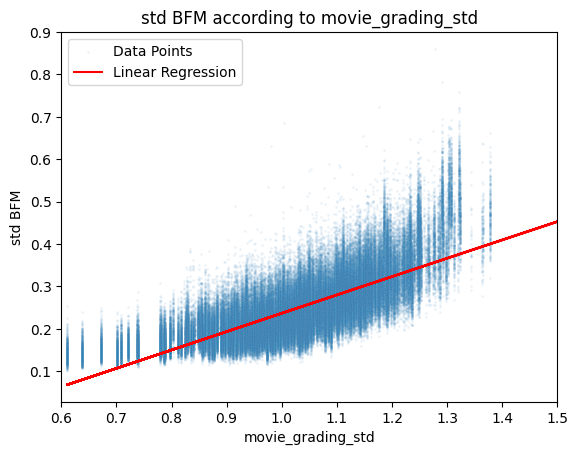

In [143]:
slope, intercept = np.polyfit(data_analysis['movie_grading_std'], data_analysis['std'], 1)

# Create the plot using seaborn
sns.scatterplot(x=data_analysis['movie_grading_std'], y=data_analysis['std'], label='Data Points', alpha=0.1,s=3)

# Calculate the regression line values
regression_line = slope * data_analysis['movie_grading_std'] + intercept

# Draw the regression line on the plot
plt.plot(data_analysis['movie_grading_std'], regression_line, color='red', label='Linear Regression')
plt.xlim(0.6, 1.5)


# Add labels and legend
plt.xlabel('movie_grading_std')
plt.ylabel('std BFM')
plt.legend()
plt.title('std BFM according to movie_grading_std')

# Show the plot
plt.show()

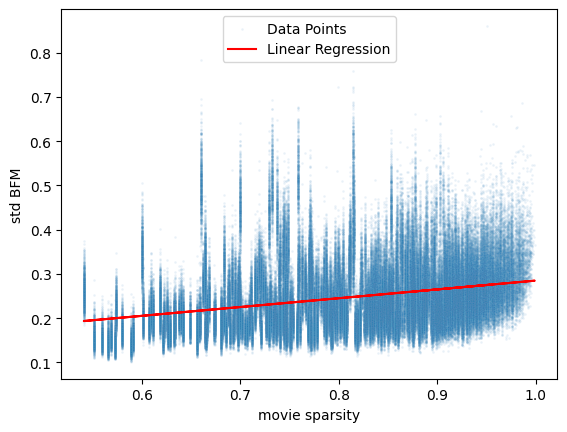

In [63]:
slope, intercept = np.polyfit(data_analysis['movie_sparsity'], data_analysis['std'], 1)

# Create the plot using seaborn
sns.scatterplot(x=data_analysis['movie_sparsity'], y=data_analysis['std'], label='Data Points', alpha=0.1,s=3)

# Calculate the regression line values
regression_line = slope * data_analysis['movie_sparsity'] + intercept

# Draw the regression line on the plot
plt.plot(data_analysis['movie_sparsity'], regression_line, color='red', label='Linear Regression')

# Add labels and legend
plt.xlabel('movie sparsity')
plt.ylabel('std BFM')
plt.legend()

# Show the plot
plt.show()

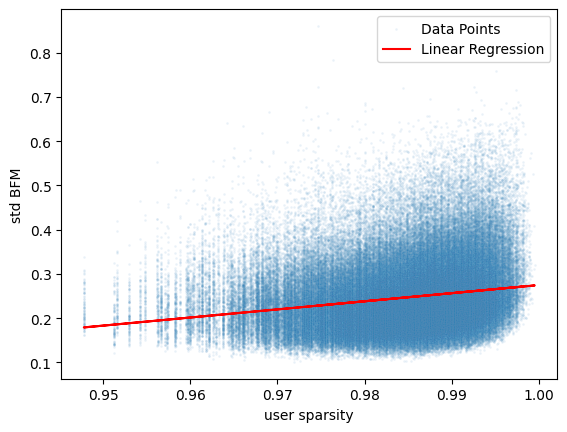

In [64]:
slope, intercept = np.polyfit(data_analysis['user_sparsity'], data_analysis['std'], 1)

# Create the plot using seaborn
sns.scatterplot(x=data_analysis['user_sparsity'], y=data_analysis['std'], label='Data Points', alpha=0.1,s=3)

# Calculate the regression line values
regression_line = slope * data_analysis['user_sparsity'] + intercept

# Draw the regression line on the plot
plt.plot(data_analysis['user_sparsity'], regression_line, color='red', label='Linear Regression')

# Add labels and legend
plt.xlabel('user sparsity')
plt.ylabel('std BFM')
plt.legend()

# Show the plot
plt.show()

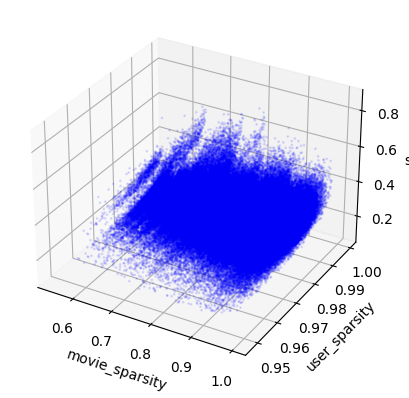

In [99]:
from mpl_toolkits import mplot3d


x = data_analysis['movie_sparsity']
y = data_analysis['user_sparsity']
z = data_analysis['std']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data
ax.scatter(x, y, z, c='b', marker='o',alpha=0.1, s=1)

# Set labels for each axis
ax.set_xlabel('movie_sparsity')
ax.set_ylabel('user_sparsity')
ax.set_zlabel('std')

# Show the plot
plt.show()

In [100]:
from sklearn.linear_model import LinearRegression

X = np.column_stack((x, y))

# Create a linear regression model
model = LinearRegression()

# Fit the model to the data
model.fit(X, z)

# Get the coefficients (slope) and intercept of the plane
coef_x, coef_y = model.coef_
intercept = model.intercept_

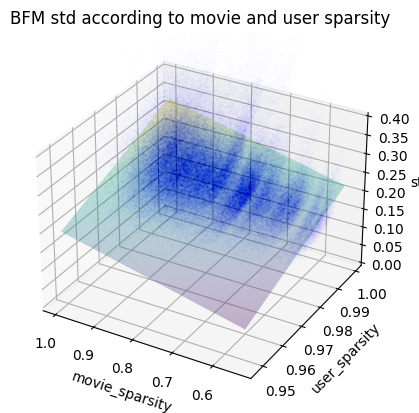

In [102]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data points
ax.scatter(x, y, z, c='b', marker='o', label='Data',alpha=0.005,s=1)
ax.invert_xaxis()
# Create a meshgrid to plot the plane
x_grid, y_grid = np.meshgrid(np.linspace(min(x), max(x), 100), np.linspace(min(y), max(y), 100))
z_plane = coef_x * x_grid + coef_y * y_grid + intercept

# Plot the plane
ax.plot_surface(x_grid, y_grid, z_plane, alpha=0.3, cmap='viridis', label='Plane Regression')

# Set labels for each axis
ax.set_xlabel('movie_sparsity')
ax.set_ylabel('user_sparsity')
ax.set_zlabel('std')

ax.set_zlim(0, 0.4)
plt.title('BFM std according to movie and user sparsity')

plt.savefig('3d_plot.png', dpi=500)
# Show the plot
plt.show()

In [11]:
prediction_bfm_ppf_df = prediction_bfm_ppf_temp.merge(std_bfm_val, left_index=True, right_index=True)
prediction_bfm_ppf_df

,Prediction,std
Id,,
r5062_c706,3.562892,0.254181
r9044_c148,3.944348,0.176798
r1736_c169,4.054189,0.208818
r5270_c877,3.869830,0.280618
r6100_c691,3.750074,0.271408
...,...,...
r1990_c61,3.986388,0.151111
r3900_c177,3.831144,0.210532
r8964_c860,3.386589,0.291268


In [127]:
val_ncf_data_scope = val_data.merge(prediction_ncf_df['Prediction'], left_index=True, right_index=True)
val_bfm_ppf_data_scope = val_data.merge(prediction_bfm_ppf_df['Prediction'], left_index=True, right_index=True)
val_mlp_data_scope = val_data.merge(prediction_mlp_df['Prediction'], left_index=True, right_index=True)
val_knn_data_scope = val_data.merge(prediction_knn_df['Prediction'], left_index=True, right_index=True)
val_bfm_ppf_data_scope.head()

,UserId,MovieId,Rating,Prediction
Id,,,,
r5062_c706,5061,705,2,3.562892
r9044_c148,9043,147,4,3.944348
r1736_c169,1735,168,4,4.054189
r5270_c877,5269,876,1,3.869830
r6100_c691,6099,690,4,3.750074


In [128]:
from math import sqrt

rmse_ncf = val_ncf_data_scope.groupby(by="MovieId").apply(lambda x: sqrt(np.mean((x['Rating'] - x['Prediction']) ** 2)))
rmse_ncf_df = pd.DataFrame(rmse_ncf, columns=['RMSE'])

# rmse_bfm_ppf = val_bfm_ppf_data_scope.groupby(by="MovieId").apply(lambda x: sqrt(np.mean((x['Rating'] - x['Prediction']) ** 2)))
# rmse_bfm_ppf_df = pd.DataFrame(rmse_bfm_ppf, columns=['RMSE'])

rmse_bfm_ppf = val_bfm_ppf_data_scope.groupby(by="MovieId").apply(lambda x: np.mean((x['Rating'] - x['Prediction']) ** 2))
rmse_bfm_ppf_df = pd.DataFrame(rmse_bfm_ppf, columns=['RMSE'])

rmse_mlp = val_mlp_data_scope.groupby(by="MovieId").apply(lambda x: sqrt(np.mean((x['Rating'] - x['Prediction']) ** 2)))
rmse_mlp_df = pd.DataFrame(rmse_mlp, columns=['RMSE'])

rmse_knn = val_knn_data_scope.groupby(by="MovieId").apply(lambda x: sqrt(np.mean((x['Rating'] - x['Prediction']) ** 2)))
rmse_knn_df = pd.DataFrame(rmse_knn, columns=['RMSE'])
rmse_bfm_ppf_df.head()

,RMSE
MovieId,
0,0.930225
1,0.836169
2,1.193718
3,1.221449
4,1.116570


In [129]:
prediction_ncf_analysis = pd.merge(data_analysis, rmse_ncf_df,left_on='MovieId', right_index=True, how='inner')

prediction_bfm_ppf_analysis_temp = pd.merge(data_analysis, rmse_bfm_ppf_df,left_on='MovieId', right_index=True, how='inner')
prediction_bfm_ppf_analysis = prediction_bfm_ppf_analysis_temp.merge(std_bfm_val, left_index=True, right_index=True)

prediction_mlp_analysis = pd.merge(data_analysis, rmse_mlp_df,left_on='MovieId', right_index=True, how='inner')

prediction_knn_analysis = pd.merge(data_analysis, rmse_knn_df,left_on='MovieId', right_index=True, how='inner')

prediction_bfm_ppf_analysis.head()

,UserId,MovieId,Rating,movie_sparsity,movie_grading_avg,movie_grading_std,user_sparsity,user_grading_avg,user_grading_std,Prediction,std_x,mse,RMSE,std_y
r44_c5,43,4,5,0.8757,3.559131,1.036532,0.9746,3.893701,1.074553,3.805640,0.178439,1.426495,1.11657,0.178439
r108_c5,107,4,3,0.8757,3.559131,1.036532,0.9782,3.775229,1.094574,3.300181,0.234224,0.090109,1.11657,0.234224
r930_c5,929,4,5,0.8757,3.559131,1.036532,0.9617,3.856397,1.311549,3.746804,0.211374,1.570500,1.11657,0.211374
r1230_c5,1229,4,1,0.8757,3.559131,1.036532,0.9633,3.803815,1.324294,3.517805,0.207188,6.339343,1.11657,0.207188
r1622_c5,1621,4,5,0.8757,3.559131,1.036532,0.9584,4.451923,1.028554,4.222128,0.191334,0.605085,1.11657,0.191334


In [130]:
prediction_knn_analysis.head()

,UserId,MovieId,Rating,movie_sparsity,movie_grading_avg,movie_grading_std,user_sparsity,user_grading_avg,user_grading_std,Prediction,std,mse,RMSE
r44_c5,43,4,5,0.8757,3.559131,1.036532,0.9746,3.893701,1.074553,3.805640,0.178439,1.426495,1.092936
r108_c5,107,4,3,0.8757,3.559131,1.036532,0.9782,3.775229,1.094574,3.300181,0.234224,0.090109,1.092936
r930_c5,929,4,5,0.8757,3.559131,1.036532,0.9617,3.856397,1.311549,3.746804,0.211374,1.570500,1.092936
r1230_c5,1229,4,1,0.8757,3.559131,1.036532,0.9633,3.803815,1.324294,3.517805,0.207188,6.339343,1.092936
r1622_c5,1621,4,5,0.8757,3.559131,1.036532,0.9584,4.451923,1.028554,4.222128,0.191334,0.605085,1.092936


In [131]:
prediction_bfm_ppf_analysis.sort_values(by="std").plot(x='std', y='RMSE', kind='scatter',marker='+',color='blue', alpha=0.01).set_title('Absolute error as a function of std for bfm_ppf')

KeyError: 'std'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


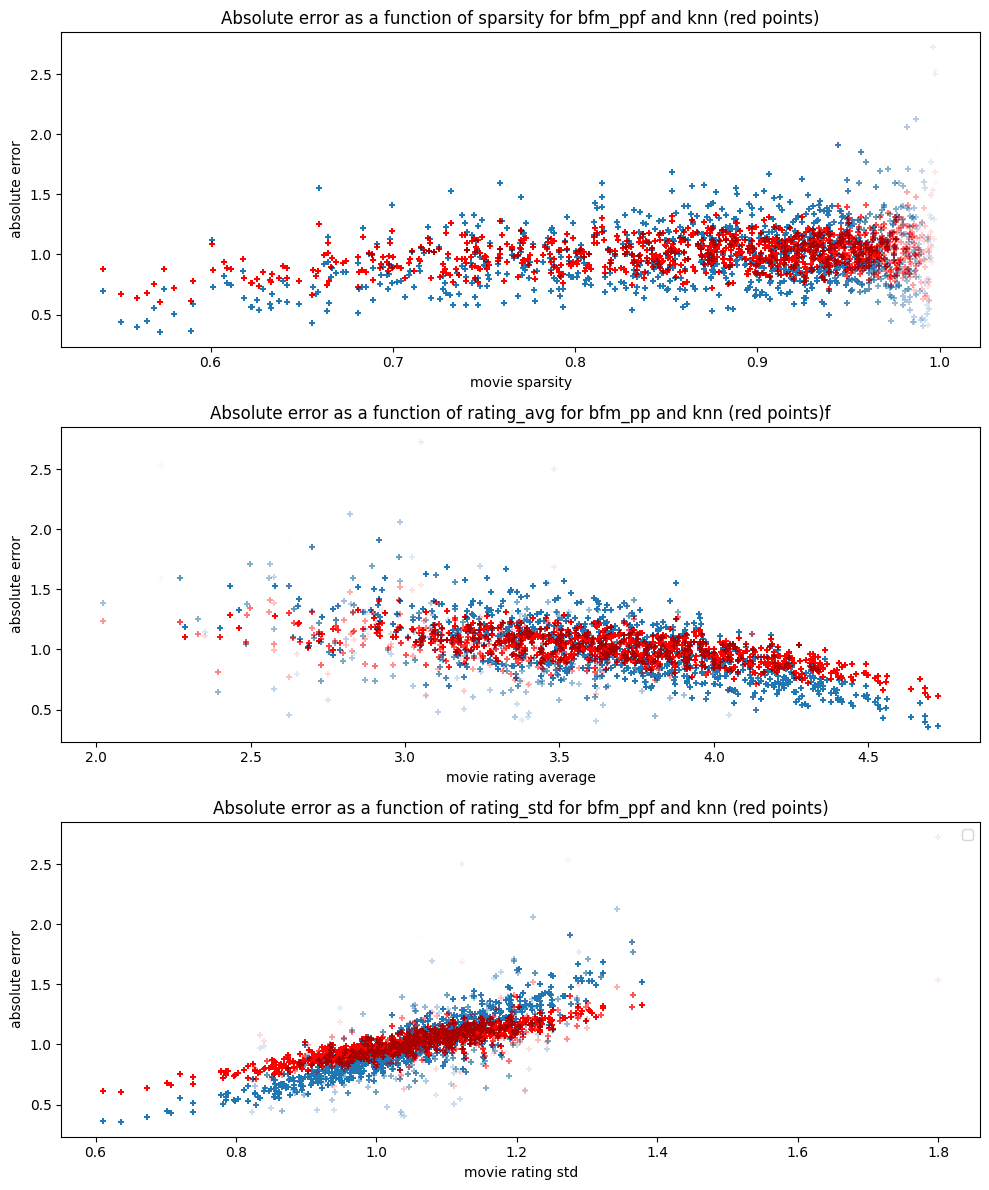

<Figure size 640x480 with 0 Axes>

In [142]:
fig, axs = plt.subplots(3, 1, figsize=(10, 12))
# Plot the data on each subplot
prediction_bfm_ppf_analysis.sort_values(by="movie_sparsity").plot(x='movie_sparsity', y='RMSE', kind='scatter',marker='+',alpha=0.01, ax=axs[0])
axs[0].set_title('Absolute error as a function of sparsity for bfm_ppf')
prediction_knn_analysis.sort_values(by="movie_sparsity").plot(x='movie_sparsity', y='RMSE', kind='scatter',color='red',marker='+',alpha=0.01, ax=axs[0])
axs[0].set_title('Absolute error as a function of sparsity for bfm_ppf and knn (red points)')
axs[0].set_xlabel('movie sparsity')
axs[0].set_ylabel('absolute error')


prediction_bfm_ppf_analysis.sort_values(by="movie_grading_avg").plot(x='movie_grading_avg', y='RMSE', kind='scatter',marker='+',alpha=0.01, ax=axs[1])
axs[1].set_title('Absolute error as a function of gradxing_avg for bfm_ppf')
prediction_knn_analysis.sort_values(by="movie_grading_avg").plot(x='movie_grading_avg', y='RMSE', kind='scatter',color='red',marker='+',alpha=0.01, ax=axs[1])
axs[1].set_title('Absolute error as a function of rating_avg for bfm_pp and knn (red points)f')
axs[1].set_xlabel('movie rating average')
axs[1].set_ylabel('absolute error')

prediction_bfm_ppf_analysis.sort_values(by="movie_grading_std").plot(x='movie_grading_std', y='RMSE', kind='scatter',marker='+',alpha=0.01, ax=axs[2])
axs[2].set_title('Absolute error as a function of grading_std for bfm_ppf')
prediction_knn_analysis.sort_values(by="movie_grading_std").plot(x='movie_grading_std', y='RMSE',color='red',marker='+', kind='scatter',alpha=0.01, ax=axs[2])
axs[2].set_title('Absolute error as a function of rating_std for bfm_ppf and knn (red points)')
axs[2].set_xlabel('movie rating std')
axs[2].set_ylabel('absolute error')

plt.legend()
# Adjust the spacing between subplots
plt.tight_layout()
# Show the plots
a = 1
plt.show()

plt.savefig('analysis_plot.png', dpi=500)

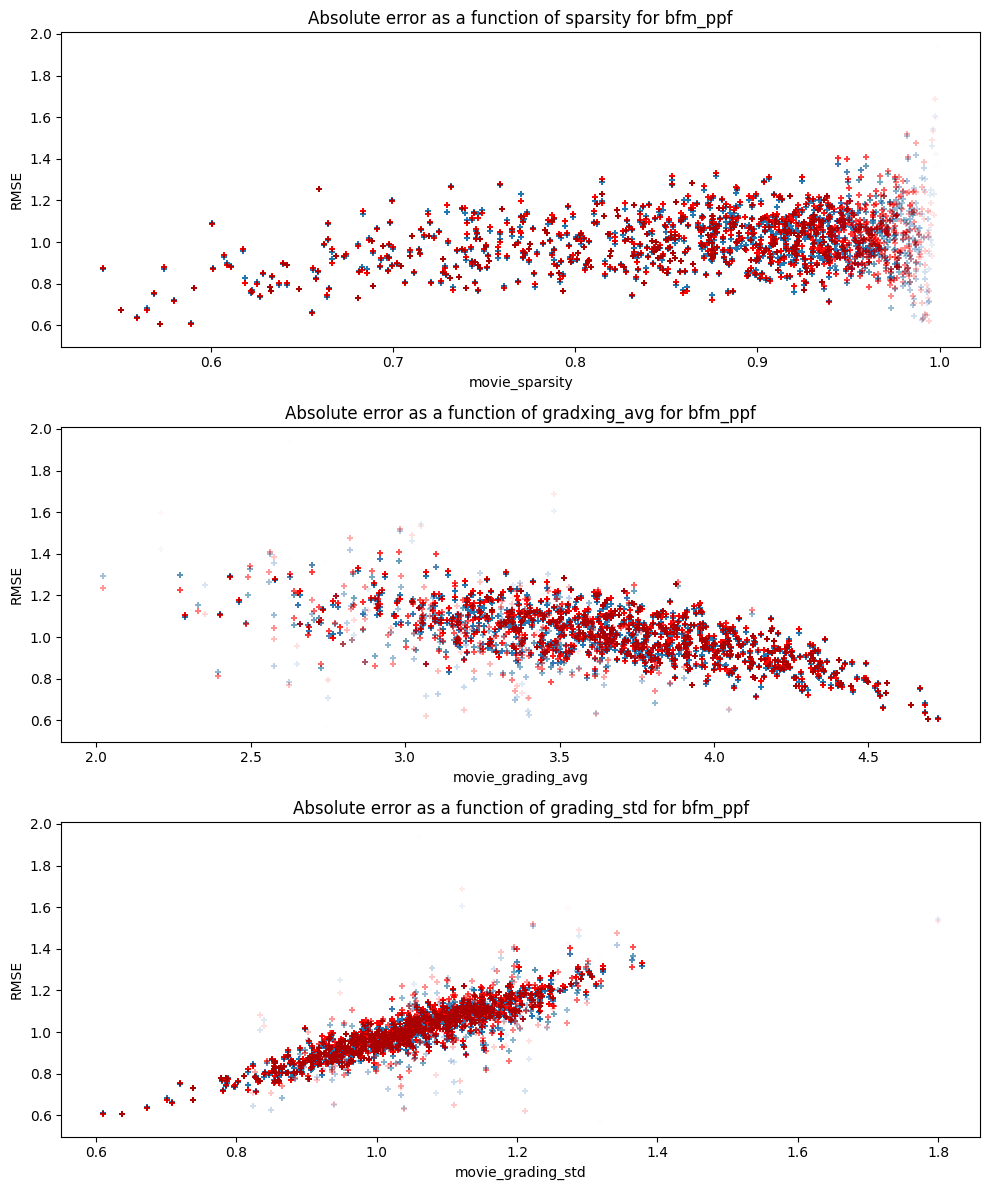

<Figure size 640x480 with 0 Axes>

In [137]:
fig, axs = plt.subplots(3, 1, figsize=(10, 12))
# Plot the data on each subplot
prediction_ncf_analysis.sort_values(by="movie_sparsity").plot(x='movie_sparsity', y='RMSE', kind='scatter',marker='+',alpha=0.01, ax=axs[0])
axs[0].set_title('Absolute error as a function of sparsity for bfm_ppf')
prediction_knn_analysis.sort_values(by="movie_sparsity").plot(x='movie_sparsity', y='RMSE', kind='scatter',color='red',marker='+',alpha=0.01, ax=axs[0])
axs[0].set_title('Absolute error as a function of sparsity for bfm_ppf')

prediction_ncf_analysis.sort_values(by="movie_grading_avg").plot(x='movie_grading_avg', y='RMSE', kind='scatter',marker='+',alpha=0.01, ax=axs[1])
axs[1].set_title('Absolute error as a function of gradxing_avg for bfm_ppf')
prediction_knn_analysis.sort_values(by="movie_grading_avg").plot(x='movie_grading_avg', y='RMSE', kind='scatter',color='red',marker='+',alpha=0.01, ax=axs[1])
axs[1].set_title('Absolute error as a function of gradxing_avg for bfm_ppf')


prediction_ncf_analysis.sort_values(by="movie_grading_std").plot(x='movie_grading_std', y='RMSE', kind='scatter',marker='+',alpha=0.01, ax=axs[2])
axs[2].set_title('Absolute error as a function of grading_std for bfm_ppf')
prediction_knn_analysis.sort_values(by="movie_grading_std").plot(x='movie_grading_std', y='RMSE',color='red',marker='+', kind='scatter',alpha=0.01, ax=axs[2])
axs[2].set_title('Absolute error as a function of grading_std for bfm_ppf')

# Adjust the spacing between subplots
plt.tight_layout()
# Show the plots
a = 1
plt.show()

plt.savefig('RMSE as a function of sparsity for ncf.png')